## Causal Impact Analysis of Media Campaign on Sales
### Bayesian structure time series modeling (BSTS) using pymc


This notebook illustrates the causal impact of a media campaign on sales using Bayesian Structural Time Series (BSTS) with the pymc_experimental.statespace module. A significant positive causal impact of the media campaign was identified in the post-intervention period. Using PyMC provides full control over priors, such as half-normal priors for external predictors, ensuring that coefficient estimates for media spend are positive. Building such a model with PyMC is more flexible but generally requires more effort compared to using other libraries like Pybuc.

In [ ]:
#Python 3.9.19
#pymc==5.12.0
#pymc-experimental==0.0.18
#pytensor==2.19.0
#numpyro==0.15.0


In [44]:
#!pip install pymc_experimental

In [43]:
#!pip install scipy==1.12.0

In [45]:
#!pip install patsy

In [1]:
import pymc_experimental as pmx

In [2]:
import jax

jax.config.update("jax_platform_name", "cpu")
import numpyro

numpyro.set_host_device_count(8)

import sys

sys.path.append("..")
from pymc_experimental.statespace import structural as st
from pymc_experimental.statespace.utils.constants import SHORT_NAME_TO_LONG, MATRIX_NAMES
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt
import numpy as np
import pandas as pd
from patsy import dmatrix
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
from sklearn.metrics import r2_score

### Generate sales and media spend data

In [3]:


np.random.seed(123)

# Function to create media spend pattern
def create_media_spend_pattern(n_days, min_on=10, max_on=30, min_off=30, max_off=90, spend_range=(100, 300)):
    pattern = np.zeros(n_days)
    current_day = 0
    while current_day < n_days:
        on_period = np.random.randint(min_on, max_on)
        off_period = np.random.randint(min_off, max_off)
        end_on_period = min(current_day + on_period, n_days)
        pattern[current_day:end_on_period] = np.random.uniform(spend_range[0], spend_range[1], end_on_period - current_day)
        current_day = end_on_period + off_period
    return pattern

# Function to create sales data with similar pattern
def create_sales_data(start_date, end_date):
    # Create dates range
    timestamps = pd.date_range(start=start_date, end=end_date, freq='D')
    n_days = len(timestamps)

    # Create a DataFrame
    df = pd.DataFrame({
        'Date': timestamps,
        'Sales': np.zeros(n_days),
        'Media_YouTube': np.zeros(n_days),
        'Media_Amazon': np.zeros(n_days),
        'Media_TikTok': np.zeros(n_days)
    })

    # Define sales patterns for each phase
    intro_growth = np.linspace(10, 100, num=int(n_days*1/6))
    growth = np.linspace(100, 1000 + np.random.randint(0, 200), num=int(n_days*1/3))
    maturity = np.linspace(1000 + np.random.randint(0, 200), 900, num=int(n_days*1/6))
    decline = np.linspace(900, 500, num=n_days - len(intro_growth) - len(growth) - len(maturity))

    # Combine the sales patterns
    sales = np.concatenate([intro_growth, growth, maturity, decline])

    # Apply the sales pattern to the DataFrame
    df['Sales'] = sales

    # Generate media spend patterns for each channel
    df['Media_YouTube'] = create_media_spend_pattern(n_days)
    df['Media_Amazon'] = create_media_spend_pattern(n_days)
    df['Media_TikTok'] = create_media_spend_pattern(n_days)

    # Increase sales when media is on
    media_active_index = (df['Media_YouTube'] > 0) | (df['Media_Amazon'] > 0) | (df['Media_TikTok'] > 0)
    df.loc[media_active_index, 'Sales'] *= 1.1  # Increase by 10% when any media is active

    # Add slight day-to-day sales variability
    df['Sales'] += np.random.normal(0, 50, size=n_days)
    df['Sales'] = df['Sales'].clip(lower=0)

    # Create an index to apply holiday effects
    holiday_index = df['Date'].apply(lambda x: x.month in [12, 1, 7] and x.day in [1, 4, 23, 30])

    # Increase sales on holidays by a factor (e.g., 1.2)
    df.loc[holiday_index, 'Sales'] *= 1.2

    # Round sales to integer values
    df['Sales'] = df['Sales'].round(0).astype(int)
    df['Holiday'] = np.where(holiday_index, 1, 0)

    return df

# Generate 2022 data
df_2022 = create_sales_data(start_date='2022-01-01', end_date='2022-12-31')

# Generate 2023 data with similar pattern
df_2023 = create_sales_data(start_date='2023-01-01', end_date='2023-12-31')

# Concatenate both dataframes
df_all = pd.concat([df_2022, df_2023]).reset_index(drop=True)

df_all.head()



,Date,Sales,Media_YouTube,Media_Amazon,Media_TikTok,Holiday
0,2022-01-01,0,238.176971,204.231886,163.028605,1
1,2022-01-02,48,243.830062,216.126404,198.302128,0
2,2022-01-03,0,198.223787,161.839800,264.028408,0
3,2022-01-04,68,256.005552,283.976525,126.524091,1
4,2022-01-05,0,182.184875,231.069501,124.261896,0


In [4]:
df_all[df_all.Date>='2023-09-01']

,Date,Sales,Media_YouTube,Media_Amazon,Media_TikTok,Holiday
608,2023-09-01,1057,298.919746,0.000000,298.360927,0
609,2023-09-02,1031,103.144003,0.000000,273.706772,0
610,2023-09-03,1008,275.132656,0.000000,132.999601,0
611,2023-09-04,929,182.010901,0.000000,137.064382,0
612,2023-09-05,1056,272.413728,0.000000,236.037228,0
...,...,...,...,...,...,...
725,2023-12-27,512,0.000000,173.792126,0.000000,0
726,2023-12-28,538,0.000000,155.631872,0.000000,0
727,2023-12-29,669,0.000000,210.803095,0.000000,0
728,2023-12-30,722,0.000000,162.852223,0.000000,1


### Generate campaign effect

In [4]:
df=df_all.copy()
campaign_start = pd.Timestamp('2023-09-01')
campaign_end = pd.Timestamp('2023-11-30')

campaign_index = df['Date'].between(campaign_start, campaign_end)
df.loc[campaign_index, 'Sales'] *= 1.3
df.loc[campaign_index, 'Sales'] = df.loc[campaign_index, 'Sales'].round(0).astype(int)

df.index=df.Date
df.drop('Date', axis=1,inplace=True)

/var/folders/m8/8x18gbj154n8f2pcjn2xp2yr0000gn/T/ipykernel_1245/618463762.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1374.1 1340.3 1310.4 1207.7 1372.8 1185.6 1268.8 1276.6 1293.5 1302.6
 1233.7 1192.1 1190.8 1307.8 1188.2 1272.7 1105.  1402.7 1171.3 1128.4
 1339.  1071.2 1205.1 1064.7 1132.3 1181.7  993.2 1003.6 1045.2 1040.
 1158.3  960.7 1128.4  950.3  943.8 1047.8  971.1  867.1 1008.8 1132.3
  952.9  981.5 1014.   955.5  897.  1002.3  932.1  988.  1107.6 1194.7
 1116.7 1045.2 1038.7 1033.5  972.4 1123.2 1025.7  981.5  977.6 1050.4
  956.8  939.9 1016.6  816.4  906.1  813.8 1003.6  973.7  920.4  833.3
  838.5  908.7  933.4  812.5  786.5  825.5  850.2  786.5  794.3  768.3
  794.3  835.9  908.7  825.5  759.2  724.1  764.4  712.4  848.9  850.2
  852.8]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[campaign_index, 'Sales'] *= 1.3


In [7]:
df.index

DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', name='Date', length=730, freq=None)

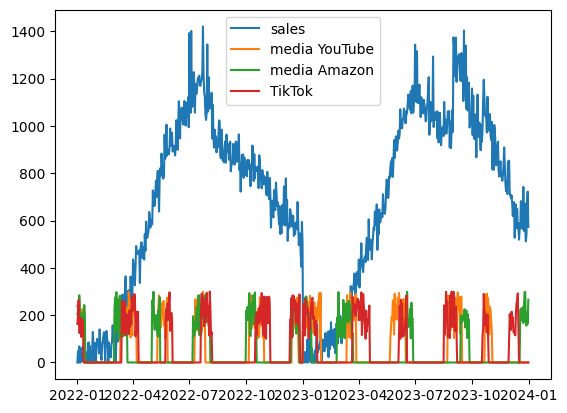

In [5]:
plt.plot(df['Sales'], label='sales')
plt.plot(df['Media_YouTube'], label='media YouTube')
plt.plot(df['Media_Amazon'],label='media Amazon')
plt.plot(df['Media_TikTok'], label='TikTok')
plt.legend()
plt.show()

### Generate pre- and post- internvetion data for modeling

In [8]:
pre_period_df=df[df.index<campaign_start]
post_period_df=df[df.index>=campaign_start]

In [9]:
post_period_df

,Sales,Media_YouTube,Media_Amazon,Media_TikTok,Holiday
Date,,,,,
2023-09-01,1374.0,298.919746,0.000000,298.360927,0
2023-09-02,1340.0,103.144003,0.000000,273.706772,0
2023-09-03,1310.0,275.132656,0.000000,132.999601,0
2023-09-04,1208.0,182.010901,0.000000,137.064382,0
2023-09-05,1373.0,272.413728,0.000000,236.037228,0
...,...,...,...,...,...
2023-12-27,512.0,0.000000,173.792126,0.000000,0
2023-12-28,538.0,0.000000,155.631872,0.000000,0
2023-12-29,669.0,0.000000,210.803095,0.000000,0


In [10]:

scaler = MinMaxScaler()

pre_period_df1 = pre_period_df.drop(columns='Sales')
# Fitting and transforming the data
pre_period_df_s = scaler.fit_transform(pre_period_df1)

# combined transformed Xs with sales 
pre_period_df_s = pd.DataFrame(pre_period_df_s, columns=pre_period_df1.columns)
pre_period_df_s['Sales'] = pre_period_df['Sales'].values
pre_period_df_s.index=pre_period_df.index

In [11]:
post_period_df1 = post_period_df.drop(columns='Sales')
post_period_df_s = scaler.transform(post_period_df1)

# combined transformed Xs with sales
post_period_df_s = pd.DataFrame(post_period_df_s, columns=post_period_df1.columns)
post_period_df_s['Sales'] = post_period_df['Sales'].values
post_period_df_s.index=post_period_df.index

In [12]:
pre_period_df_s.index=pd.DatetimeIndex(pre_period_df_s.index, freq='D')
post_period_df_s.index=pd.DatetimeIndex(post_period_df_s.index, freq='D')

### Build state space model

In [13]:
mod = st.LevelTrendComponent(order=2, innovations_order=[0, 1])
mod += st.AutoregressiveComponent(order=1)
mod += st.MeasurementError(name="error")
mod+=st.RegressionComponent(name="exog", k_exog=4, innovations=False)
ss_mod = mod.build(name="sales")

The following parameters should be assigned priors inside a PyMC model block: 
	initial_trend -- shape: (2,), constraints: None, dims: ('trend_state',)
	sigma_trend -- shape: (1,), constraints: Positive, dims: ('trend_shock',)
	ar_params -- shape: (1,), constraints: None, dims: ('ar_lag',)
	sigma_ar -- shape: (1,), constraints: Positive, dims: None
	sigma_error -- shape: (1,), constraints: Positive, dims: ('observed_state',)
	beta_exog -- shape: (1,), constraints: None, dims: ('exog_state',)
	P0 -- shape: (7, 7), constraints: Positive semi-definite, dims: ('state', 'state_aux')
The following MutableData variables should be assigned to the model inside a PyMC model block: 
	data_exog -- shape: (None, 4), dims: ('time', 'exog_state')


In [14]:
ss_mod.param_dims.values()


dict_values([('trend_state',), ('trend_shock',), ('ar_lag',), ('observed_state',), ('exog_state',), ('state', 'state_aux')])

In [15]:
initial_trend_dims, sigma_trend_dims, ar_param_dims,sigma_error_dims, beta_exog_dims,P0_dims = ss_mod.param_dims.values()
coords = ss_mod.coords

In [16]:
coords

{'trend_state': ['level', 'trend'],
 'trend_shock': ['trend'],
 'ar_lag': [1],
 'exog_state': ['exog_1', 'exog_2', 'exog_3', 'exog_4'],
 'state': ['level',
  'trend',
  'L1.data',
  'exog_1',
  'exog_2',
  'exog_3',
  'exog_4'],
 'state_aux': ['level',
  'trend',
  'L1.data',
  'exog_1',
  'exog_2',
  'exog_3',
  'exog_4'],
 'observed_state': ['sales'],
 'observed_state_aux': ['sales'],
 'shock': ['trend',
  'AutoRegressive_innovation',
  'exog_1',
  'exog_2',
  'exog_3',
  'exog_4'],
 'shock_aux': ['trend',
  'AutoRegressive_innovation',
  'exog_1',
  'exog_2',
  'exog_3',
  'exog_4']}

In [15]:
P0_dims

('state', 'state_aux')

In [32]:
#coords_mutable = {'obs': np.arange(len(pre_period_df))}

### Train the model with pymc on pre intervention data

In [17]:
# Define the PyMC model
with pm.Model(coords=coords) as model:
    # Priors for the parameters
    obs_data=pre_period_df_s['Sales']
    exog_data=pre_period_df_s[['Media_YouTube','Media_Amazon','Media_TikTok',	'Holiday']]

    initial_trend = pm.Normal("initial_trend", mu=0, sigma=1, dims=initial_trend_dims)
    sigma_trend = pm.HalfNormal("sigma_trend", sigma=1, dims=sigma_trend_dims)
   # sigma_trend = pm.Gamma("sigma_trend", alpha=2, beta=10, dims=sigma_trend_dims)
    ar_params = pm.Normal("ar_params", mu=0, sigma=1, dims=ar_param_dims)
    sigma_ar = pm.HalfNormal("sigma_ar", sigma=1,shape=(1,))
    #sigma_ar = pm.Gamma("sigma_ar", alpha=5,beta=5, shape=(1,))
    sigma_error = pm.HalfNormal("sigma_error", sigma=1)
    beta_exog = pm.HalfNormal("beta_exog",  sigma=5, dims=beta_exog_dims)

    # Constraint for P0 to be positive semi-definite
    P0_diag = pm.Gamma("P0_diag", alpha=5, beta=5)
    P0 = pm.Deterministic("P0", np.eye(ss_mod.k_states) * P0_diag, dims=P0_dims)

    # Mutable data variables
    data_exog = pm.MutableData("data_exog",  exog_data)

# To fit the model, you would then proceed with model fitting steps such as sampling.

    ss_mod.build_statespace_graph( obs_data, mode="FAST_COMPILE")

    idata = pm.sample(nuts_sampler="numpyro", chains=4, draws=300)

  0%|          | 0/1300 [00:00<?, ?it/s]

  0%|          | 0/1300 [00:00<?, ?it/s]

  0%|          | 0/1300 [00:00<?, ?it/s]

  0%|          | 0/1300 [00:00<?, ?it/s]

array([[<Axes: title={'center': 'initial_trend'}>,
        <Axes: title={'center': 'initial_trend'}>],
       [<Axes: title={'center': 'ar_params'}>,
        <Axes: title={'center': 'ar_params'}>],
       [<Axes: title={'center': 'sigma_trend'}>,
        <Axes: title={'center': 'sigma_trend'}>],
       [<Axes: title={'center': 'sigma_ar'}>,
        <Axes: title={'center': 'sigma_ar'}>],
       [<Axes: title={'center': 'sigma_error'}>,
        <Axes: title={'center': 'sigma_error'}>],
       [<Axes: title={'center': 'beta_exog'}>,
        <Axes: title={'center': 'beta_exog'}>],
       [<Axes: title={'center': 'P0_diag'}>,
        <Axes: title={'center': 'P0_diag'}>]], dtype=object)

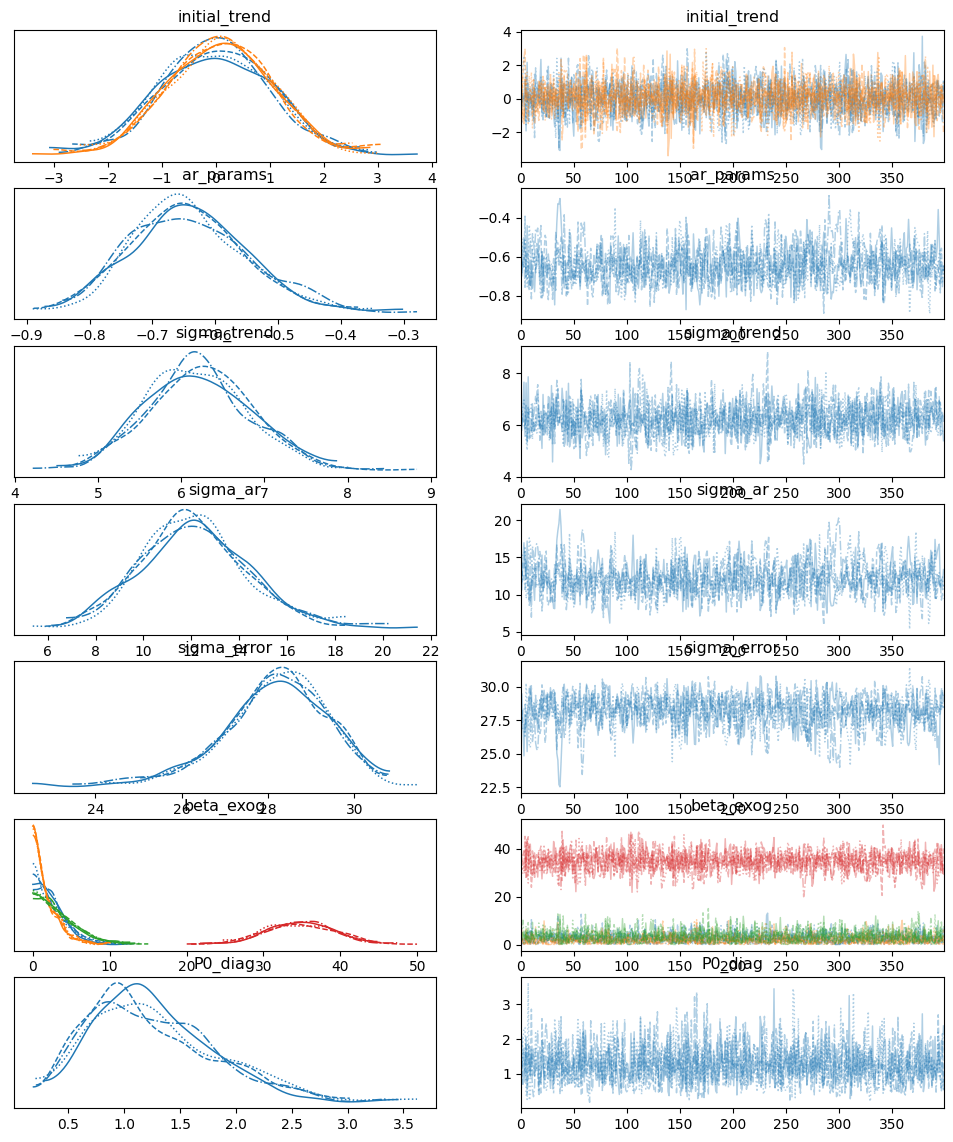

In [22]:
az.plot_trace(idata, var_names=["~P0"])

#### In-sample prediction evaluation (based on conditional posterior hidden states)

In [18]:
post_pred = ss_mod.sample_conditional_posterior(idata)

Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


In [62]:
data_p = post_pred.filtered_posterior_observed.isel(draw=slice(30, None))
predicted_y_mean=data_p.mean(dim=["chain", "draw"]).isel(observed_state=0)

0.9992028998472436


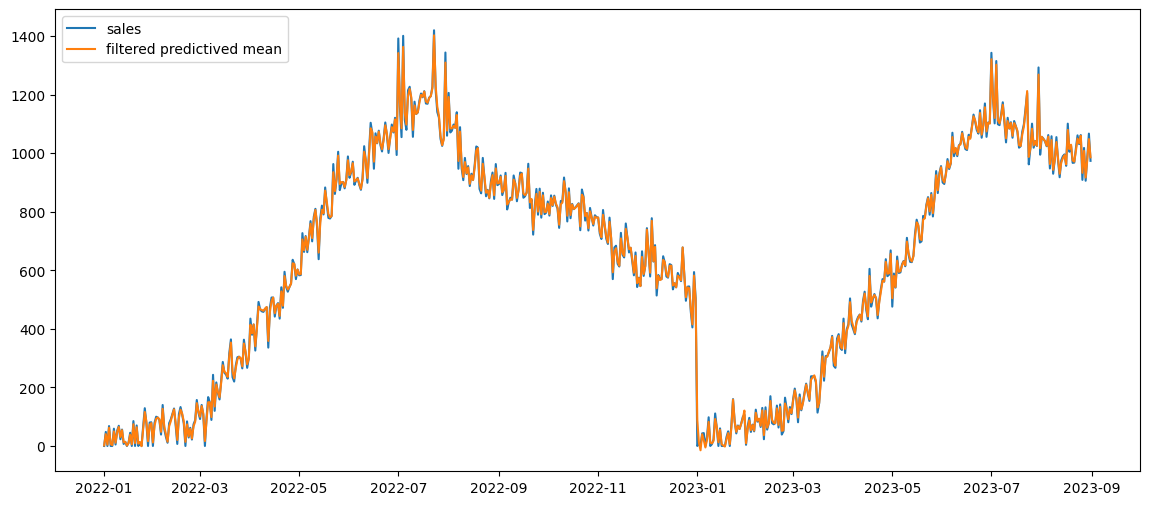

In [63]:

plt.figure(figsize=(14,6))
plt.plot(pre_period_df_s.Sales, label='sales')
plt.plot(predicted_y_mean.time,predicted_y_mean.values, label='filtered predictived mean')
r2 = r2_score(pre_period_df.Sales,predicted_y_mean.values)

print(r2)
plt.legend()

In [60]:
data_p2 = post_pred.predicted_posterior_observed.isel(draw=slice(30, None))
predicted_y_mean=data_p2.mean(dim=["chain", "draw"]).isel(observed_state=0)

0.9572066359617469


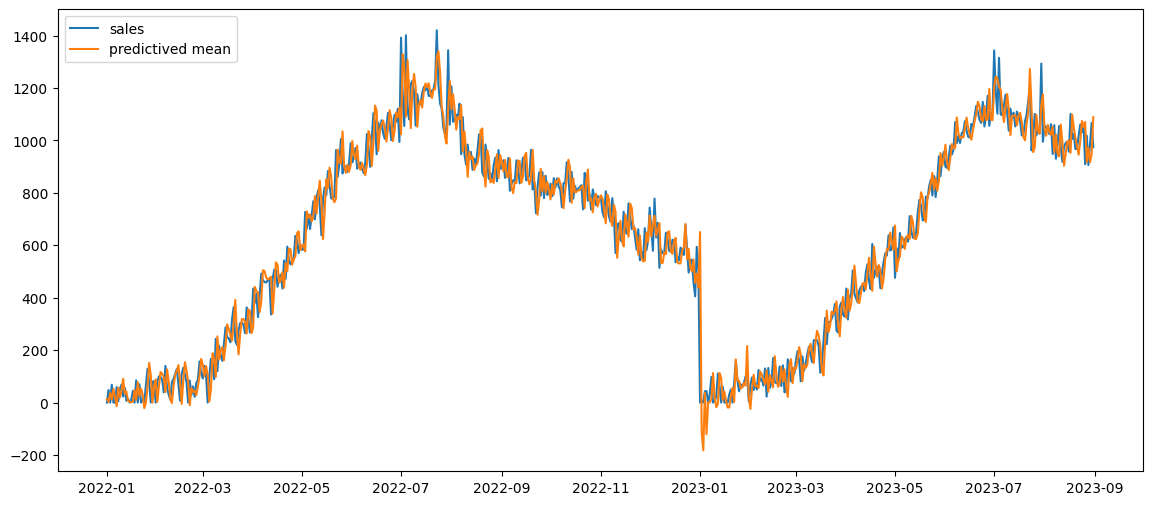

In [61]:
from sklearn.metrics import r2_score
plt.figure(figsize=(14,6))
plt.plot(pre_period_df_s.Sales, label='sales')
plt.plot(predicted_y_mean.time,predicted_y_mean.values, label='predictived mean')
r2 = r2_score(pre_period_df.Sales,predicted_y_mean.values)

print(r2)
plt.legend()

In [27]:
component_idata = ss_mod.extract_components_from_idata(post_pred)
component_states=component_idata.coords['state'].values.tolist()

Variables predicted_posterior_observed, smoothed_posterior_observed, filtered_posterior_observed do not contain all hidden states (their last dimension is not 7). They will not be present in the modified idata.


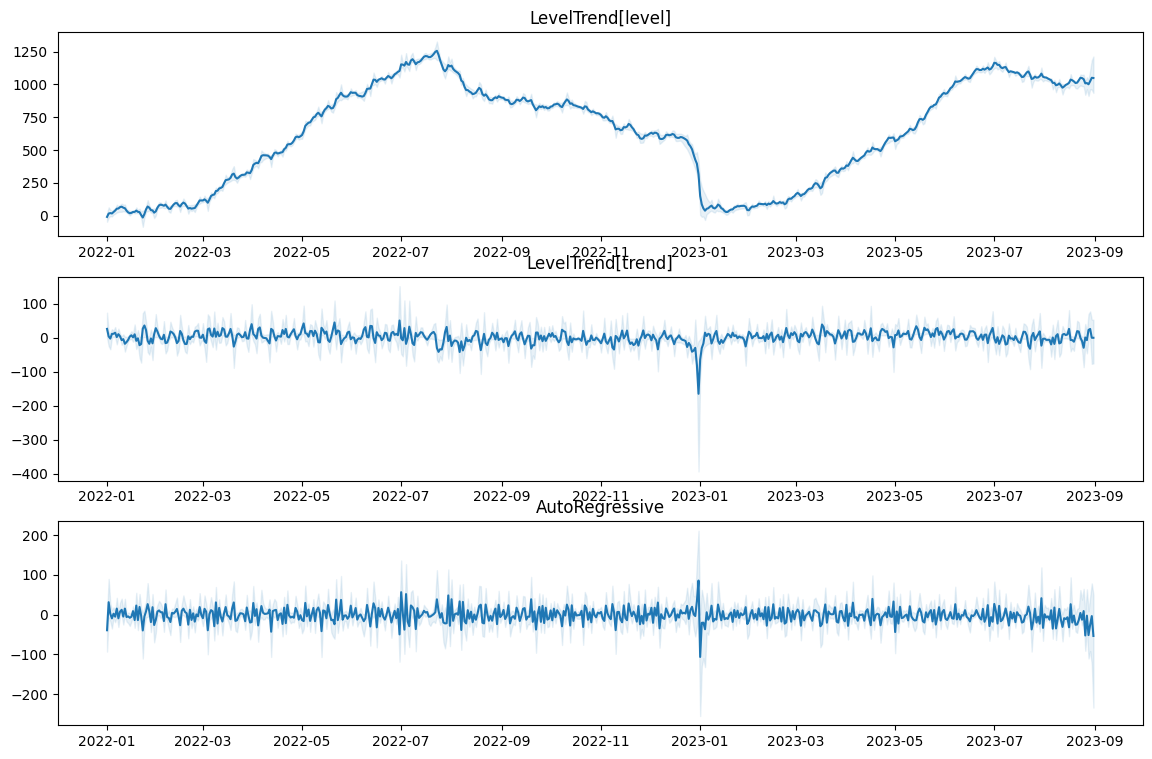

In [28]:
fig, ax = plt.subplots(3, 1, figsize=(14, 9))
x_values = component_idata.coords["time"]
for axis, name in zip(fig.axes, component_states):
    data = component_idata.smoothed_posterior.sel(state=name)
    hdi = az.hdi(data).smoothed_posterior
    mean = data.mean(dim=["chain", "draw"])

    axis.plot(x_values, mean)
    axis.fill_between(x_values, *hdi.values.T, color="tab:blue", alpha=0.1)
    axis.set_title(name)
plt.show()

### Generate posterior predictives for post intervention data

In [29]:
pre_period_df.shape

(608, 5)

In [30]:
post_period_df.shape

(122, 5)

In [66]:
idx1=pre_period_df_s.index.get_loc('2022-09-01')
#idx2=pre_period_df_s.index.get_loc('2022-12-31')

In [67]:
padded_post_period_df = pd.DataFrame(np.zeros((len(pre_period_df_s), 4)), columns=post_period_df_s.columns[0:4])

In [68]:
start_row = idx1
end_row = start_row + len(post_period_df_s)

padded_post_period_df.iloc[start_row:end_row] = post_period_df_s[['Media_YouTube','Media_Amazon','Media_TikTok','Holiday']].values

In [65]:
#def pad_data(data, target_length):
#    padding_length = target_length - data.shape[0]
#    if padding_length > 0:
#        padding = np.full((padding_length, data.shape[1]), 0)  # Using 0s for padding
#        padded_data = np.vstack([ padding,data])
#    else:
#        padded_data = data
#    return padded_data

#target_length = pre_period_df_s.shape[0]
#padded_post_period_df = pad_data(post_period_df_s.drop('Sales',axis=1), target_length)

In [70]:


with model:
    pm.set_data( {"data_exog": padded_post_period_df}) 
   #             coords={'obs':np.arange( len(pre_period_df))})
    pp = pm.sample_posterior_predictive(idata, predictions=True, var_names=['obs'])

Sampling: [obs]


In [21]:
len(post_period_df)

122

In [34]:
az.summary(idata, round_to=3, kind="stats")

,mean,sd,hdi_3%,hdi_97%
initial_trend[level],-0.021,0.978,-1.823,1.842
initial_trend[trend],0.152,0.968,-1.673,1.890
ar_params[1],-0.650,0.089,-0.810,-0.478
sigma_trend[trend],6.176,0.606,5.084,7.337
sigma_ar[0],11.975,2.177,8.155,16.351
sigma_error,28.296,1.111,26.224,30.235
beta_exog[exog_1],2.480,1.996,0.001,6.078
beta_exog[exog_2],1.781,1.510,0.009,4.694
beta_exog[exog_3],3.346,2.572,0.002,8.115
beta_exog[exog_4],34.885,4.174,26.416,42.024


In [71]:
pp.predictions['obs'].isel(draw=slice(30, None),time=slice(start_row,end_row))

<xarray.DataArray 'obs' (chain: 4, draw: 270, time: 122, observed_state: 1)> Size: 1MB
array([[[[ 882.39871139],
         [ 969.51743459],
         [ 928.10895665],
         ...,
         [ 527.76406243],
         [ 387.89907168],
         [ 481.74438589]],

        [[ 927.1926289 ],
         [ 953.8606828 ],
         [ 943.46780436],
         ...,
         [ 492.49770651],
         [ 405.99661702],
         [ 460.43228426]],

        [[ 887.91052576],
         [ 894.0857891 ],
         [ 883.10195306],
         ...,
...
         ...,
         [ 491.5210488 ],
         [ 481.76732128],
         [ 439.95116691]],

        [[ 888.56454397],
         [ 895.86739112],
         [1002.1449545 ],
         ...,
         [ 500.9766842 ],
         [ 460.91662853],
         [ 415.40569237]],

        [[ 876.07474457],
         [ 852.77738747],
         [ 847.97069115],
         ...,
         [ 467.05834015],
         [ 389.74072231],
         [ 492.77262602]]]])
Coordinates:
  * chain           (chain) int64 32B 0 1 2 3
  * draw            (draw) int64 2kB 30 31 32 33 34 35 ... 295 296 297 298 299
  * time            (time) datetime64[ns] 976B 2022-09-01 ... 2022-12-31
  * observed_state  (observed_state) <U5 20B 'sales'

In [73]:

pp.predictions['obs']
#extracted_data = pp.predictions['obs'].isel(draw=slice(100, None),time=slice(0, len(post_period_df)))
extracted_data=pp.predictions['obs'].isel(draw=slice(30, None),time=slice(start_row,end_row))
post_period_pred=extracted_data.mean(dim=["chain", "draw"]).isel(observed_state=0)

In [90]:
#post_period_pred

### Extract causal impact of the campaign

In [75]:
impact=xr.DataArray(post_period_df['Sales'].values,dims='time')-post_period_pred

impact_c=impact.cumsum(dim='time')


In [76]:
hdi_forecast = az.hdi(extracted_data).isel(observed_state=0)


In [77]:
hdi_forecast

<xarray.Dataset> Size: 3kB
Dimensions:         (time: 122, hdi: 2)
Coordinates:
  * time            (time) datetime64[ns] 976B 2022-09-01 ... 2022-12-31
    observed_state  <U5 20B 'sales'
  * hdi             (hdi) <U6 48B 'lower' 'higher'
Data variables:
    obs             (time, hdi) float64 2kB 859.7 1.028e+03 ... 370.9 532.5

Text(0.5, 1.0, 'Actual vs Posterior Sales with HDI Forecast')

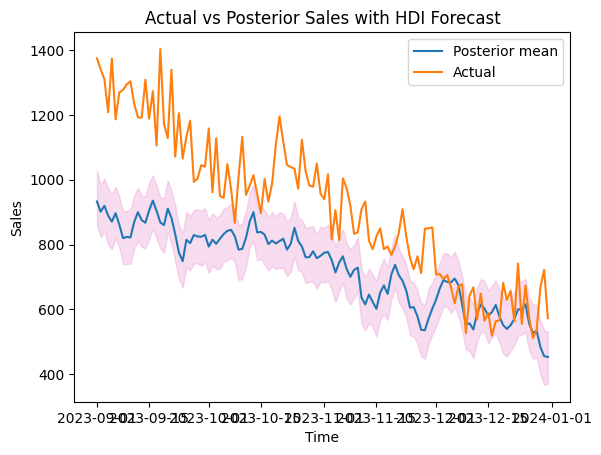

In [78]:
fig, ax = plt.subplots()
forecast_time=post_period_df.index
ax.plot(forecast_time, post_period_pred, label='Posterior mean')
ax.plot(post_period_df.index, post_period_df.Sales, label='Actual')
ax.fill_between(forecast_time, *hdi_forecast['obs'].values.T, alpha=0.25, color="tab:pink")
ax.legend()

ax.set_xlabel('Time')
ax.set_ylabel('Sales')
ax.set_title('Actual vs Posterior Sales with HDI Forecast')

Text(0.5, 1.0, 'Post-intervention causal impact')

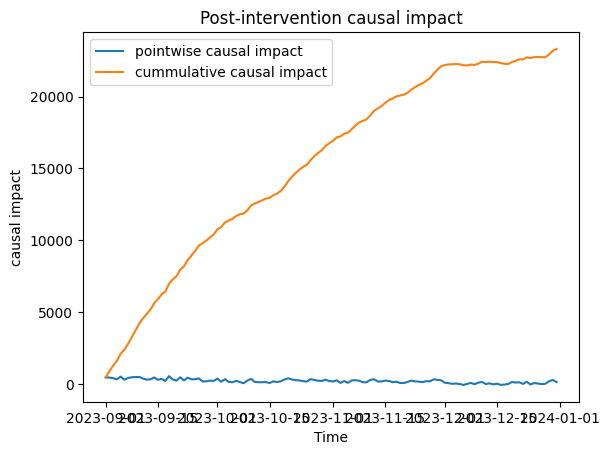

In [79]:
fig, ax = plt.subplots()
ax.plot(forecast_time,impact, label='pointwise causal impact')
ax.plot(forecast_time,impact_c, label='cummulative causal impact')
ax.legend()

ax.set_xlabel('Time')
ax.set_ylabel('causal impact')
ax.set_title('Post-intervention causal impact')

In [80]:
post_point_resp = post_period_df_s.Sales.values
mean_resp = post_point_resp.mean()
mean_resp_fmt=int(mean_resp)
cum_resp = post_point_resp.sum()
cum_resp_fmt=int(cum_resp)

post_point_pred=post_period_pred.values
mean_pred = post_point_pred.mean()
mean_pred_fmt=int(mean_pred)
cum_pred = post_point_pred.sum()
cum_pred_fmt=int(cum_pred)

post_point_lower = hdi_forecast['obs'].values.T[0]
post_point_upper=hdi_forecast['obs'].values.T[1]
mean_lower = post_point_lower.mean()
mean_lower_fmt = int(mean_lower)
mean_upper = post_point_upper.mean()
mean_upper_fmt = int(mean_upper)
mean_ci_fmt = [mean_lower_fmt, mean_upper_fmt]
cum_lower = post_point_lower.sum()
cum_lower_fmt = int(cum_lower)
cum_upper = post_point_upper.sum()
cum_upper_fmt = int(cum_upper)
cum_ci_fmt = [cum_lower_fmt, cum_upper_fmt]


abs_effect = (post_point_resp - post_point_pred).mean()
abs_effect_fmt = int(abs_effect)
cum_abs_effect = (post_point_resp - post_point_pred).sum()
cum_abs_effect_fmt = int(cum_abs_effect)
abs_effect_lower = (post_point_resp - post_point_lower).mean()
abs_effect_lower_fmt = int(abs_effect_lower)
abs_effect_upper = (post_point_resp - post_point_upper).mean()
abs_effect_upper_fmt = int(abs_effect_upper)
abs_effect_ci_fmt = [abs_effect_lower_fmt, abs_effect_upper_fmt]
cum_abs_lower = (post_point_resp - post_point_lower).sum()
cum_abs_lower_fmt = int(cum_abs_lower)
cum_abs_upper = (post_point_resp - post_point_upper).sum()
cum_abs_upper_fmt = int(cum_abs_upper)
cum_abs_effect_ci_fmt = [cum_abs_lower_fmt, cum_abs_upper_fmt]



rel_effect = abs_effect / mean_pred * 100
rel_effect_fmt = "{:.1f}%".format(rel_effect)
cum_rel_effect = cum_abs_effect / cum_pred * 100
cum_rel_effect_fmt = "{:.1f}%".format(cum_rel_effect)
rel_effect_lower = abs_effect_lower / mean_pred * 100
rel_effect_lower_fmt = "{:.1f}%".format(rel_effect_lower)
rel_effect_upper = abs_effect_upper / mean_pred * 100
rel_effect_upper_fmt = "{:.1f}%".format(rel_effect_upper)
rel_effect_ci_fmt = [rel_effect_lower_fmt, rel_effect_upper_fmt]
cum_rel_effect_lower = cum_abs_lower / cum_pred * 100
cum_rel_effect_lower_fmt = "{:.1f}%".format(cum_rel_effect_lower)
cum_rel_effect_upper = cum_abs_upper / cum_pred * 100
cum_rel_effect_upper_fmt = "{:.1f}%".format(cum_rel_effect_upper)
cum_rel_effect_ci_fmt = [cum_rel_effect_lower_fmt, cum_rel_effect_upper_fmt]

In [81]:
import scipy.stats as stat
# assuming approximately normal distribution
        # calculate standard deviation from the 95% conf interval
std_pred = (mean_upper - mean_pred) / 1.88  # from mean_upper = mean_pred + 1.96 * std
        # calculate z score
z_score = (post_period_df_s.Sales.mean() - mean_pred) / std_pred
        # pvalue from zscore
p_value = stat.norm.cdf(z_score) # one sided p-value
p_value_upper = 1 - p_value
p_value_perc = p_value_upper 
prob_causal_perc = (1-p_value_perc ) * 100


In [85]:
summary = [
                [mean_resp_fmt, cum_resp_fmt],
                [mean_pred_fmt, cum_pred_fmt],
                [mean_ci_fmt, cum_ci_fmt],
                [" ", " "],
                [abs_effect_fmt, cum_abs_effect_fmt],
                [abs_effect_ci_fmt, cum_abs_effect_ci_fmt],
                [" ", " "],
                [rel_effect_fmt, cum_rel_effect_fmt],
                [rel_effect_ci_fmt, cum_rel_effect_ci_fmt],
                [" ", " "],
                ["{:.2f}".format(p_value_perc), " "],
                ["{:.1f}%".format(prob_causal_perc), " "],
            ]
summary = pd.DataFrame(
                summary,
                columns=["Average", "Cumulative"],
                index=[
                    "Actual",
                    "Predicted",
                    "95% CI",
                    " ",
                    "Absolute Effect",
                    "95% CI",
                    " ",
                    "Relative Effect",
                    "95% CI",
                    " ",
                    "P-value",
                    "Prob. of Causal Effect",
                ],
            )
summary

,Average,Cumulative
Actual,922,112530
Predicted,731,89209
95% CI,"[647, 813]","[78985, 99210]"
,,
Absolute Effect,191,23320
95% CI,"[274, 109]","[33544, 13319]"
,,
Relative Effect,26.1%,26.1%
95% CI,"[37.6%, 14.9%]","[37.6%, 14.9%]"
,,
